Feature statistics before scaling:
  T1-T2_W: mean=0.0000, std=10.4425, min=-32.0000, max=32.0000
  T1-T2_PIE: mean=0.0000, std=3.2917, min=-11.5000, max=11.5000
  T1-T2_eFG%: mean=0.0000, std=2.4626, min=-8.2000, max=8.2000
  T1-T2_OREB%: mean=0.0000, std=3.3072, min=-10.6000, max=10.6000
  T1-T2_DREB%: mean=0.0000, std=2.0915, min=-5.9000, max=5.9000
  T1-T2_TS%: mean=0.0000, std=2.2894, min=-7.8000, max=7.8000
  T1vT2_Off-Def: mean=4.3228, std=3.4889, min=-5.4000, max=14.9000
  T2vT1_Off-Def: mean=4.3228, std=3.4889, min=-5.4000, max=14.9000
Scaler saved as C:\Users\jonla\NBA_Playoffs_Series_Predictor\Models\scaler.pkl
Scaler statistics:
  T1-T2_W: mean=0.0000, std=10.4425
  T1-T2_PIE: mean=0.0000, std=3.2917
  T1-T2_eFG%: mean=0.0000, std=2.4626
  T1-T2_OREB%: mean=0.0000, std=3.3072
  T1-T2_DREB%: mean=0.0000, std=2.0915
  T1-T2_TS%: mean=0.0000, std=2.2894
  T1vT2_Off-Def: mean=4.3228, std=3.4889
  T2vT1_Off-Def: mean=4.3228, std=3.4889
NBA_Playoff_NN CV Accuracy: 0.7341 ± 0.0199

C:\Users\jonla\AppData\Local\Temp\ipykernel_16044\1789132946.py:167: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  plt.annotate(f"Idx {int(row['Index'])}",


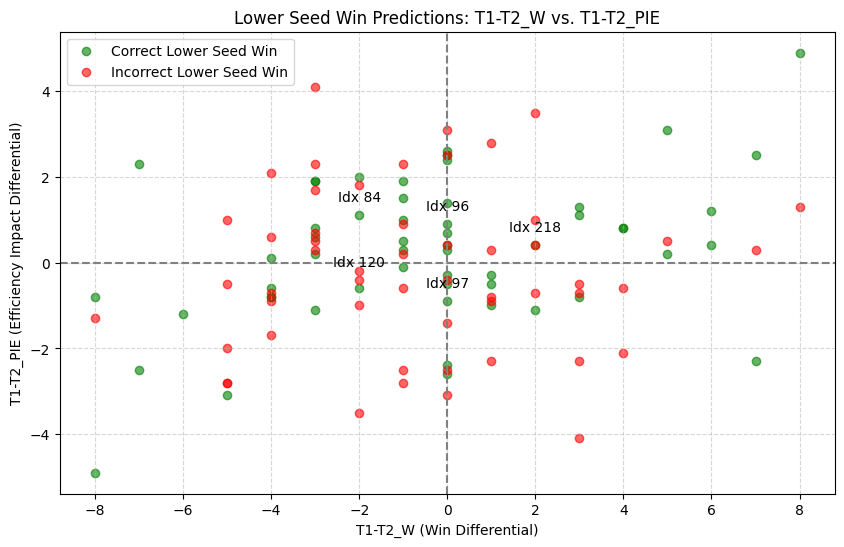

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import pickle

# Load data
master_df = pd.read_csv(r"C:\Users\jonla\NBA_Playoffs_Series_Predictor\Data\master_playoff_advanced_stats.csv")
master_df = master_df.dropna(subset=['Winner_OffRtg', 'Loser_OffRtg'])
master_df = master_df.reset_index(drop=True)

stats = ["NetRtg", "PIE", "W", "L", "OffRtg", "DefRtg", "AST%", "AST/TO", 
         "AST Ratio", "OREB%", "DREB%", "REB%", "TOV%", "eFG%", "TS%", "PACE", "POSS"]
inputs = ['T1-T2_W', 'T1-T2_PIE', 'T1-T2_eFG%', 'T1-T2_OREB%', 'T1-T2_DREB%', 
          'T1-T2_TS%', 'T1vT2_Off-Def', 'T2vT1_Off-Def']

# Shuffle and double data
np.random.seed(42)
df = pd.DataFrame()
for i in range(len(master_df)):
    winner_seed = float(master_df.loc[i, "Winner_Seed"])
    loser_seed = float(master_df.loc[i, "Loser_Seed"])
    winner_stats = master_df.loc[i, [f"Winner_{stat}" for stat in stats]].values.astype(float)
    loser_stats = master_df.loc[i, [f"Loser_{stat}" for stat in stats]].values.astype(float)
    
    row1 = pd.Series([winner_seed] + list(winner_stats) + [loser_seed] + list(loser_stats) + [0], 
                     index=["T1_Seed"] + [f"T1_{stat}" for stat in stats] + 
                           ["T2_Seed"] + [f"T2_{stat}" for stat in stats] + ["T2_Wins"])
    row2 = pd.Series([loser_seed] + list(loser_stats) + [winner_seed] + list(winner_stats) + [1], 
                     index=["T1_Seed"] + [f"T1_{stat}" for stat in stats] + 
                           ["T2_Seed"] + [f"T2_{stat}" for stat in stats] + ["T2_Wins"])
    
    if np.random.rand() > 0.5:
        df = pd.concat([df, row1.to_frame().T, row2.to_frame().T], ignore_index=True)
    else:
        df = pd.concat([df, row2.to_frame().T, row1.to_frame().T], ignore_index=True)

# Compute differences
df = df.astype(float)
df['T1vT2_Off-Def'] = df["T1_OffRtg"] - df["T2_DefRtg"]
df['T2vT1_Off-Def'] = df["T2_OffRtg"] - df["T1_DefRtg"]
df['T1-T2_W'] = df["T1_W"] - df["T2_W"]
df['T1-T2_PIE'] = df["T1_PIE"] - df["T2_PIE"]
df['T1-T2_eFG%'] = df["T1_eFG%"] - df["T2_eFG%"]
df['T1-T2_OREB%'] = df["T1_OREB%"] - df["T2_OREB%"]
df['T1-T2_DREB%'] = df["T1_DREB%"] - df["T2_DREB%"]
df['T1-T2_TS%'] = df["T1_TS%"] - df["T2_TS%"]

X = df[inputs].values
y = df["T2_Wins"].values

# Debug: Print feature statistics before scaling
print("Feature statistics before scaling:")
for i, feat in enumerate(inputs):
    print(f"  {feat}: mean={X[:, i].mean():.4f}, std={X[:, i].std():.4f}, min={X[:, i].min():.4f}, max={X[:, i].max():.4f}")

# Fit scaler on entire dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save scaler
with open(r"C:\Users\jonla\NBA_Playoffs_Series_Predictor\Models\scaler.pkl", 'wb') as f:
    pickle.dump(scaler, f)
print(r"Scaler saved as C:\Users\jonla\NBA_Playoffs_Series_Predictor\Models\scaler.pkl")

# Debug: Print scaler statistics
print("Scaler statistics:")
for i, feat in enumerate(inputs):
    print(f"  {feat}: mean={scaler.mean_[i]:.4f}, std={scaler.scale_[i]:.4f}")

# Define model with stronger regularization
def build_model(input_shape):
    model = Sequential([
        tf.keras.layers.Input(shape=(input_shape,)),
        Dense(32, activation='relu', kernel_regularizer=l2(0.1)),  # Stronger L2
        BatchNormalization(),
        Dropout(0.7),  # Stronger dropout
        Dense(16, activation='relu', kernel_regularizer=l2(0.1)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 5-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
all_predictions = []
all_true_labels = []
all_seeds = []
all_test_indices = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    X_train_scaled = X_scaled[train_idx]  # Use pre-scaled data
    X_test_scaled = X_scaled[test_idx]
    
    model = build_model(X.shape[1])
    early_stop = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
    model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, 
              validation_split=0.2, verbose=0, callbacks=[early_stop])
    _, acc = model.evaluate(X_test_scaled, y_test, verbose=0)
    accuracies.append(acc)
    
    preds = model.predict(X_test_scaled, verbose=0).flatten()
    pred_labels = (preds > 0.5).astype(int)
    all_predictions.extend(pred_labels)
    all_true_labels.extend(y_test)
    all_seeds.extend(df.loc[test_idx, ['T1_Seed', 'T2_Seed']].values)
    all_test_indices.extend(test_idx)

print(f"NBA_Playoff_NN CV Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print("Leak Check:")
print((df["T1_Seed"] < df["T2_Seed"]).eq(df["T2_Wins"]).mean())

# Results with features
results = pd.DataFrame({
    'T1_Seed': [s[0] for s in all_seeds],
    'T2_Seed': [s[1] for s in all_seeds],
    'True_Label': all_true_labels,
    'Pred_Label': all_predictions,
    'T1-T2_W': df.loc[all_test_indices, 'T1-T2_W'],
    'T1-T2_PIE': df.loc[all_test_indices, 'T1-T2_PIE'],
    'Index': all_test_indices
})

# Lower seed wins
lower_seed_wins = results[
    ((results['T1_Seed'] > results['T2_Seed']) & (results['Pred_Label'] == 0)) |
    ((results['T2_Seed'] > results['T1_Seed']) & (results['Pred_Label'] == 1))
]

print("\nLower Seed Win Predictions (with Key Features):")
print(lower_seed_wins[['Index', 'T1_Seed', 'T2_Seed', 'True_Label', 'Pred_Label', 'T1-T2_W', 'T1-T2_PIE']].head(10))
print(f"\nTotal Lower Seed Wins Predicted: {len(lower_seed_wins)}")
print(f"Correct Lower Seed Wins: {len(lower_seed_wins[lower_seed_wins['True_Label'] == lower_seed_wins['Pred_Label']])}")

# Save model (last fold)
model.save(r"C:\Users\jonla\NBA_Playoffs_Series_Predictor\Models\NBA_Playoff_NN.h5")
print(r"Model saved as C:\Users\jonla\NBA_Playoffs_Series_Predictor\Models\NBA_Playoff_NN.h5")

# Test model predictions on sample data
print("\nTesting model predictions on sample data...")
for i in range(5):
    X_sample = X_scaled[i:i+1]
    prob = model.predict(X_sample, verbose=0)[0][0]
    print(f"Sample {i}: Predicted probability of T2 winning: {prob:.4f}, True label: {y[i]}")

# Plot with labels for key points
correct_lower = lower_seed_wins[lower_seed_wins['True_Label'] == lower_seed_wins['Pred_Label']]
incorrect_lower = lower_seed_wins[lower_seed_wins['True_Label'] != lower_seed_wins['Pred_Label']]

plt.figure(figsize=(10, 6))
plt.scatter(correct_lower['T1-T2_W'], correct_lower['T1-T2_PIE'], c='green', label='Correct Lower Seed Win', alpha=0.6)
plt.scatter(incorrect_lower['T1-T2_W'], incorrect_lower['T1-T2_PIE'], c='red', label='Incorrect Lower Seed Win', alpha=0.6)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')

for idx in lower_seed_wins['Index'].head(5):
    row = lower_seed_wins[lower_seed_wins['Index'] == idx]
    plt.annotate(f"Idx {int(row['Index'])}", 
                 (row['T1-T2_W'].values[0], row['T1-T2_PIE'].values[0]),
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Lower Seed Win Predictions: T1-T2_W vs. T1-T2_PIE')
plt.xlabel('T1-T2_W (Win Differential)')
plt.ylabel('T1-T2_PIE (Efficiency Impact Differential)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()